In [30]:
import os, inspect, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import datetime as dt
from dateutil.relativedelta import relativedelta

import plotly.plotly as py
import plotly.graph_objs as go


CURRENT_DIR = os.path.dirname(inspect.getabsfile(inspect.currentframe()))
ROOT_DIR = os.path.dirname(CURRENT_DIR)
sys.path.insert(0, ROOT_DIR)

from reb.src.pyts import series_to_supervised

In [2]:
# monthly date range generator
def month_range(start_date, n_months):
    for m in range(n_months):
        yield start_date + relativedelta(months=+m)

In [3]:
ffname = os.path.join(ROOT_DIR, "reb", "data", "ext", "data_monthly_processed.csv")

In [4]:
df = pd.read_csv(ffname, parse_dates=["DATE"])
df.DATE = pd.to_datetime(df.DATE, format="%Y-%m")
# df = df.loc[60:, :]

df.head()


,DATE,PAYEMS,USPRIV,AWHNONAG,CES9091000001,USGOVT,UNEMPLOY,LNS13023622,LNS13023706,LNS13023654,LNS13026511,MVPHGFD027MNFRBDAL,MORTGAGE30US,MORTGAGE15US,DGS10,INDPRO,W875RX1
0,1992-01-01,108374,89686,34.1,3137,18688,9283,54.0,11.9,13.1,40.9,2719.3,8.4,8.0,7.0,63.3372,6840.9
1,1992-02-01,108317,89628,34.1,3121,18689,9454,57.0,9.8,13.6,43.3,2738.8,8.8,8.4,7.3,63.7864,6879.1
2,1992-03-01,108369,89654,34.1,3121,18715,9460,57.4,9.5,13.4,44.0,2760.5,8.9,8.6,7.5,64.3199,6884.7
3,1992-04-01,108526,89787,34.3,3117,18739,9415,57.3,10.4,13.6,43.8,2764.0,8.9,8.5,7.5,64.8069,6903.6
4,1992-05-01,108653,89900,34.3,3119,18753,9744,57.7,10.3,12.8,44.9,2830.7,8.7,8.3,7.4,65.0202,6941.7


Make a clen copy of data. This allows us to modify freely while we have always the original data for any further reference.

In [29]:
df_original = df.copy() 
print(len(df_original))

320


Reindex data frame per the time stamps

In [6]:
df.set_index("DATE", inplace=True)
df.head()

,PAYEMS,USPRIV,AWHNONAG,CES9091000001,USGOVT,UNEMPLOY,LNS13023622,LNS13023706,LNS13023654,LNS13026511,MVPHGFD027MNFRBDAL,MORTGAGE30US,MORTGAGE15US,DGS10,INDPRO,W875RX1
DATE,,,,,,,,,,,,,,,,
1992-01-01,108374,89686,34.1,3137,18688,9283,54.0,11.9,13.1,40.9,2719.3,8.4,8.0,7.0,63.3372,6840.9
1992-02-01,108317,89628,34.1,3121,18689,9454,57.0,9.8,13.6,43.3,2738.8,8.8,8.4,7.3,63.7864,6879.1
1992-03-01,108369,89654,34.1,3121,18715,9460,57.4,9.5,13.4,44.0,2760.5,8.9,8.6,7.5,64.3199,6884.7
1992-04-01,108526,89787,34.3,3117,18739,9415,57.3,10.4,13.6,43.8,2764.0,8.9,8.5,7.5,64.8069,6903.6
1992-05-01,108653,89900,34.3,3119,18753,9744,57.7,10.3,12.8,44.9,2830.7,8.7,8.3,7.4,65.0202,6941.7


In [28]:
# rescale data
values = df.values
values = values.astype("float32")
scaler = MinMaxScaler(feature_range=(0, 1))
values_scaled = scaler.fit_transform(values)
n_variables = values.shape[1]
pd.DataFrame(values_scaled)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.001391,0.001554,0.687500,0.596821,0.000000,0.385169,0.510822,0.659794,0.532609,0.530686,0.000000,0.864407,0.868852,0.846154,0.000000,0.000000
1,0.000000,0.000000,0.687500,0.573699,0.000232,0.402492,0.640693,0.443299,0.586957,0.617328,0.001820,0.932203,0.934426,0.892308,0.010006,0.005707
2,0.001269,0.000697,0.687500,0.573699,0.006267,0.403100,0.658009,0.412371,0.565217,0.642599,0.003846,0.949153,0.967213,0.923077,0.021889,0.006543
3,0.005102,0.004261,0.812500,0.567919,0.011838,0.398541,0.653679,0.505155,0.586957,0.635379,0.004173,0.949153,0.950820,0.923077,0.032737,0.009367
4,0.008203,0.007290,0.812500,0.570809,0.015088,0.431871,0.670996,0.494845,0.500000,0.675090,0.010400,0.915254,0.918033,0.907692,0.037488,0.015059
5,0.009789,0.008791,0.750002,0.567919,0.017177,0.461858,0.597402,0.484536,0.532609,0.602888,0.012453,0.881356,0.885246,0.892308,0.037726,0.019675
6,0.011596,0.009300,0.750002,0.567919,0.029944,0.442610,0.584416,0.515464,0.500000,0.602888,0.015646,0.813559,0.819672,0.815385,0.050748,0.018270
7,0.014892,0.011150,0.750002,0.556358,0.045264,0.436227,0.554113,0.608247,0.467391,0.592058,0.021359,0.796610,0.786885,0.784615,0.043604,0.022244
8,0.015673,0.013454,0.812500,0.553468,0.032730,0.435619,0.584416,0.484536,0.684783,0.537906,0.024655,0.779661,0.770492,0.753846,0.046975,0.017075
9,0.020214,0.018466,0.750002,0.528902,0.032497,0.396819,0.670996,0.422680,0.565217,0.653430,0.019371,0.813559,0.786885,0.784615,0.057947,0.011070


In [8]:
index_target = 15
# set model parameters
n_lags = 12
n_sequences = 12
n_train = int(values.shape[0] * 0.8)
n_units = 10

In [9]:
# set train parameters
optimizer = "adam"
loss = "mse"
n_epochs = 30
sz_batch = 20
verbose = 1


In [10]:
df_reframed = series_to_supervised(values_scaled, n_lags, n_sequences)
df_reframed.head()
# [print(elem) for elem in df_reframed.columns]

,var1(t-12),var2(t-12),var3(t-12),var4(t-12),var5(t-12),var6(t-12),var7(t-12),var8(t-12),var9(t-12),var10(t-12),...,var7(t+11),var8(t+11),var9(t+11),var10(t+11),var11(t+11),var12(t+11),var13(t+11),var14(t+11),var15(t+11),var16(t+11)
12,0.001391,0.001554,0.6875,0.596821,0.000000,0.385169,0.510822,0.659794,0.532609,0.530686,...,0.480519,0.628866,0.478261,0.519855,0.050532,0.661017,0.655738,0.661538,0.115063,0.071901
13,0.000000,0.000000,0.6875,0.573699,0.000232,0.402492,0.640693,0.443299,0.586957,0.617328,...,0.320346,0.432990,0.489130,0.382671,0.052054,0.644068,0.639344,0.661538,0.120794,0.045519
14,0.001269,0.000697,0.6875,0.573699,0.006267,0.403100,0.658009,0.412371,0.565217,0.642599,...,0.290043,0.463917,0.478261,0.364621,0.048544,0.661017,0.655738,0.692308,0.121253,0.046849
15,0.005102,0.004261,0.8125,0.567919,0.011838,0.398541,0.653679,0.505155,0.586957,0.635379,...,0.255411,0.422680,0.380435,0.364621,0.045444,0.745763,0.737705,0.769231,0.136743,0.050225
16,0.008203,0.007290,0.8125,0.570809,0.015088,0.431871,0.670996,0.494845,0.500000,0.675090,...,0.134199,0.432990,0.293478,0.296029,0.040235,0.847458,0.836066,0.846154,0.145548,0.061339


In [11]:
# create train/valid data
# split into train and test sets
values = df_reframed.values
train_values, valid_values = values[:n_train, :], values[n_train:, :]
print(f"Train Inputs Shape: {train_values.shape}")
print(f"Valid Inputs Shape: {valid_values.shape}")

Train Inputs Shape: (256, 384)
Valid Inputs Shape: (41, 384)


In [12]:
# split into input and targets
n_train, n_ = train_values.shape
n_valid, n_ = valid_values.shape
n_features = n_lags * n_variables


In [13]:
# split into input and targets
n_train, n_ = train_values.shape
n_valid, n_ = valid_values.shape
n_features = n_lags * n_variables


In [14]:
# split into input and targets
n_train, n_ = train_values.shape
n_valid, n_ = valid_values.shape
n_observations = n_lags * n_variables
x_train, y_train = train_values[:, :n_observations], train_values[:, n_observations+index_target:n_:n_variables]
x_valid, y_valid = valid_values[:, :n_observations], valid_values[:, n_observations+index_target:n_:n_variables]
print(f"Train Inputs Shape: {x_train.shape}, Train Targets Shape: {y_train.shape}")
print(f"Valid Inputs Shape: {x_valid.shape}, Valid Targets Shape: {y_valid.shape}")

Train Inputs Shape: (256, 192), Train Targets Shape: (256, 12)
Valid Inputs Shape: (41, 192), Valid Targets Shape: (41, 12)


In [26]:
# reshape data as required by ltsm
x_train = x_train.reshape((n_train, n_lags, n_variables))
x_valid = x_valid.reshape((n_valid, n_lags, n_variables))
print(f"Train Inputs Shape: {x_train.shape}, Train Targets Shape: {y_train.shape}")
print(f"Valid Inputs Shape: {x_valid.shape}, Valid Targets Shape: {y_valid.shape}")
x_train

Train Inputs Shape: (256, 12, 16), Train Targets Shape: (256, 12)
Valid Inputs Shape: (41, 12, 16), Valid Targets Shape: (492,)


array([[[1.39141083e-03, 1.55448914e-03, 6.87500000e-01, ...,
         8.46153855e-01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 6.87500000e-01, ...,
         8.92307758e-01, 1.00055933e-02, 5.70678711e-03],
        [1.26934052e-03, 6.96897507e-04, 6.87500000e-01, ...,
         9.23076868e-01, 2.18890905e-02, 6.54327869e-03],
        ...,
        [2.02138424e-02, 1.84664726e-02, 7.50001907e-01, ...,
         7.84615397e-01, 5.79469204e-02, 1.10697746e-02],
        [2.34363079e-02, 2.16557980e-02, 7.50001907e-01, ...,
         8.30769181e-01, 6.42551184e-02, 1.57009363e-02],
        [2.87339687e-02, 2.64801979e-02, 7.50001907e-01, ...,
         8.15384626e-01, 6.55002594e-02, 5.81723452e-02]],

       [[0.00000000e+00, 0.00000000e+00, 6.87500000e-01, ...,
         8.92307758e-01, 1.00055933e-02, 5.70678711e-03],
        [1.26934052e-03, 6.96897507e-04, 6.87500000e-01, ...,
         9.23076868e-01, 2.18890905e-02, 6.54327869e-03],
        [5.10215759e-03, 

In [16]:
# build model
model = Sequential()
model.add(LSTM(n_units, input_shape=(n_lags, n_variables)))
model.add(Dense(n_sequences))
model.compile(loss=loss, optimizer=optimizer)

In [17]:
# train model
history = model.fit(x_train, y_train,
                    epochs=n_epochs,
                    batch_size=sz_batch,
                    validation_data=(x_valid, y_valid),
                    verbose=verbose,
                    shuffle=False)

Train on 256 samples, validate on 41 samples
Epoch 1/30
256/256 [==============================] - 2s 8ms/step - loss: 0.3806 - val_loss: 0.9755
Epoch 2/30
256/256 [==============================] - 0s 2ms/step - loss: 0.2822 - val_loss: 0.8255
Epoch 3/30
256/256 [==============================] - 0s 2ms/step - loss: 0.2271 - val_loss: 0.7254
Epoch 4/30
256/256 [==============================] - 0s 2ms/step - loss: 0.1913 - val_loss: 0.6488
Epoch 5/30
256/256 [==============================] - 0s 2ms/step - loss: 0.1630 - val_loss: 0.5797
Epoch 6/30
256/256 [==============================] - 0s 2ms/step - loss: 0.1370 - val_loss: 0.5093
Epoch 7/30
256/256 [==============================] - 0s 2ms/step - loss: 0.1115 - val_loss: 0.4347

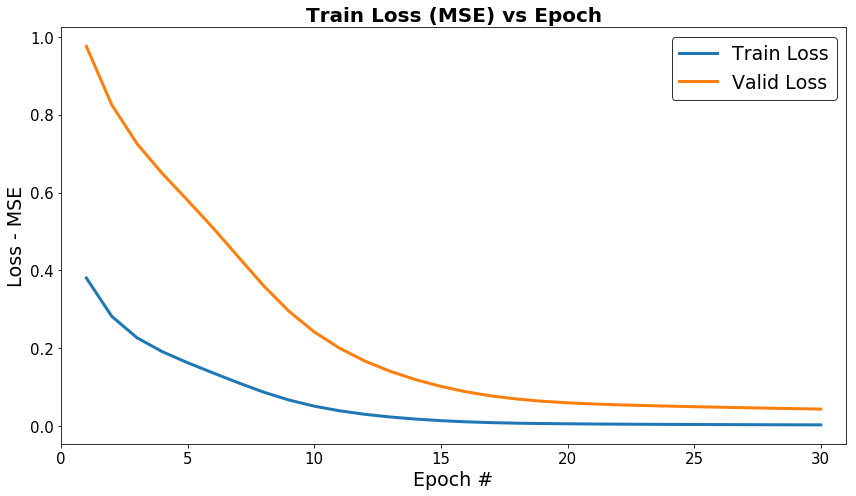

In [18]:
# plot history
figsize = (12, 7)
titlefontsize = 20
xtickfontsize = 15
ytickfontsize = 15
labelfontsize = 19
legendfontsize = 19
linewidth = 3
fig = plt.figure(figsize=figsize)
ax = fig.subplots(1, 1)
ax.plot(np.arange(1, n_epochs+1), history.history['loss'],
        "-",
        linewidth=linewidth,
        label='Train Loss')
ax.plot(np.arange(1, n_epochs+1), history.history['val_loss'],
        "-",
        linewidth=linewidth,
        label='Valid Loss')
ax.set_xlabel("Epoch #", fontsize=labelfontsize)
ax.set_ylabel("Loss - " + loss.upper(), fontsize=labelfontsize)
ax.tick_params(
    axis='x',          
    which='both',      
    labelsize=xtickfontsize)
ax.tick_params(
    axis='y',    
    labelsize=ytickfontsize)
ax.set_title("Train Loss " +  f"({loss})".upper() + " vs Epoch",
        fontsize=titlefontsize,
        fontweight="bold"
    )
ax.legend(loc="upper right",
          fontsize=legendfontsize,
          framealpha=0.8,
          fancybox=True,
          frameon=True,
          shadow=False,
          edgecolor="k")
ax.set_xlim([0, n_epochs+1])
plt.tight_layout()
fname = f"loss-plot-valid.png"
# fig.savefig(os.path.join(ROOT_DIR, "reports", "figures", fname), transparent=False, dpi=dpi)
plt.show()

In [19]:
# make a prediction
yhat_valid = model.predict(x_valid)

In [20]:
temp = x_valid.reshape((n_valid, n_lags*n_variables))
temp[-n_sequences*n_variables:][:, index_target:n_sequences*n_variables:n_variables] = \
    y_valid.reshape((n_valid, n_sequences))
temp = temp.reshape((-1, n_variables))
y_valid = scaler.inverse_transform(temp)[:, index_target]

temp = x_valid.reshape((n_valid, n_lags*n_variables))
temp[-n_sequences*n_variables:][:, index_target:n_sequences*n_variables:n_variables] = \
    yhat_valid.reshape((n_valid, n_sequences))
temp = temp.reshape((-1, n_variables))
yhat_valid = scaler.inverse_transform(temp)[:, index_target]

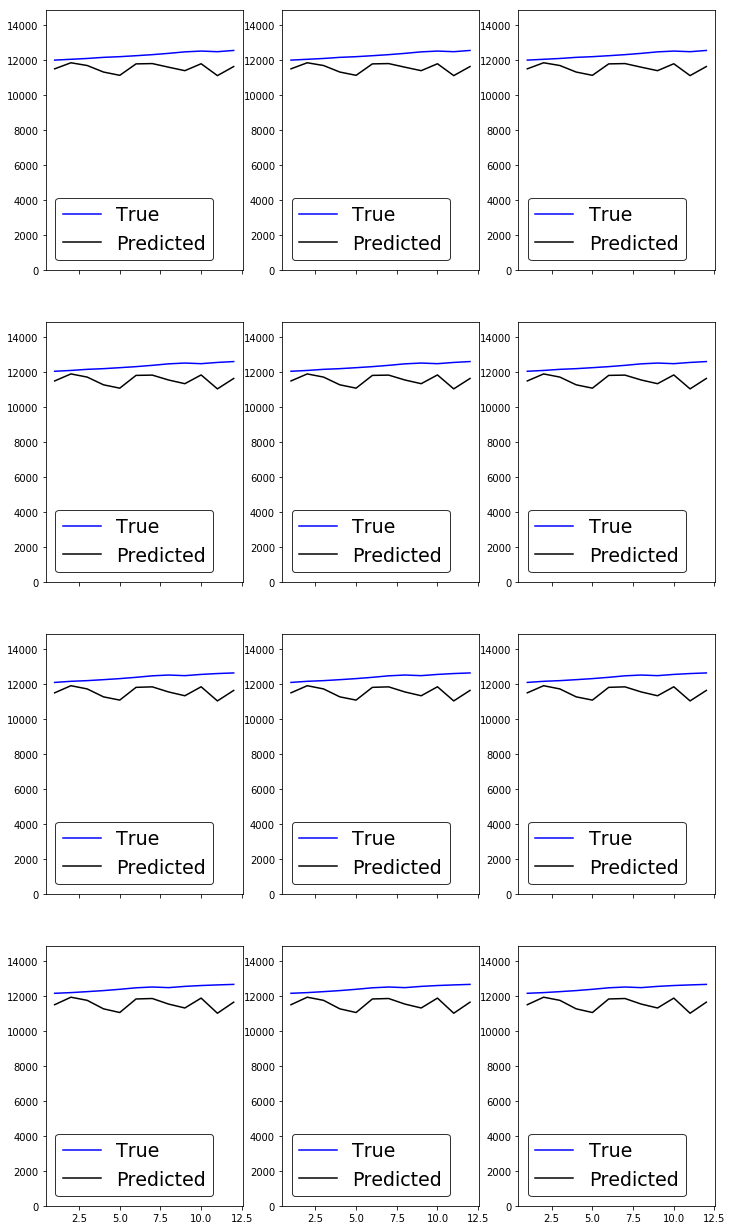

In [21]:
n = 12
ncols = 3
fig, axs = plt.subplots(nrows=int(np.ceil(n/ncols)),
                        ncols=ncols,
                        figsize=(12, 22),
                        sharex=True)
for k in range(n):
    i = k // ncols
    j = k % ncols
    axs[i, j].plot(np.arange(1,n_sequences+1),
                   y_valid[i*n_sequences:i*n_sequences+n_sequences],
                   color="blue",
                   label="True")
    axs[i, j].plot(np.arange(1,n_sequences+1),
                   yhat_valid[i*n_sequences:i*n_sequences+n_sequences],
                   color="black",
                   label="Predicted")
    
    
    axs[i, j].legend(loc="best",
                     fontsize=legendfontsize,
                     framealpha=0.8,
                     fancybox=True,
                     frameon=True,
                     shadow=False,
                     edgecolor="k")
    
    axs[i, j].set_ylim([0, 1.1*max(y_valid)])
#     print(y_valid[i*n_sequences:i*n_sequences+n_sequences].shape) 
    

Perform forecatsting

In [22]:
x_scaled = df.values[-2*n_lags:-n_lags, :].reshape((1, -1)).reshape((-1, n_sequences, n_variables))

In [23]:
yhat_scaled = model.predict(x_scaled)

temp = x_scaled.reshape((1, n_lags*n_variables))

temp[-n_sequences*n_variables:][:, index_target:n_sequences*n_variables:n_variables] = \
    yhat_scaled.reshape((1, n_sequences))
temp = temp.reshape((-1, n_variables))
yhat = scaler.inverse_transform(temp)[:, index_target]

In [32]:
start_date = df.index[-1] 
mrange = month_range(start_date, n_sequences+1)
data = []

trace = go.Scatter(
        x=list(df.index.astype(str).values),
        y=df.iloc[:, index_target],
        name="Original",
#         line = dict(color=colors[i]),
#         colorscale='Viridis',
        opacity = 0.9,
        mode="lines"
    )

trace_predict = go.Scatter(
        x=[d for d in mrange],
        y=list(df.values[-1:, index_target]) + list(yhat),
        name="Predict",
#         line = dict(color=colors[i]),
#         colorscale='Viridis',
        opacity = 0.9,
        mode="lines"
    )

data = [trace, trace_predict]

layout = dict(
    title=df.columns[index_target],
    yaxis= dict(title = df.columns[index_target]),
    xaxis=dict(
        title="Time",
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename = df.columns[index_target])

PlotlyRequestError: Aw, snap! You tried to use our API as the user 'michaelgarza', but the supplied API key doesn't match our records. You can view your API key at https://plot.ly/settings/api

You're most likely getting this message because your local credentials file isn't synced with the Plotly server you're communicating with.

Go to https://plot.ly/<language>/getting-started (e.g., https://plot.ly/python/getting-started) for more information.

Make sure that you're logged in as michaelgarza.

Need help? Please try searching Plotly's <a href='http://stackoverflow.com/questions/tagged/plotly'>Stack Overflow channel</a>.

In [25]:
yhat

array([ 7387.03158596,  3903.42886805,  9875.25058725, 11586.55199282,
        5709.65838427,  5304.81331816,  5855.99085134,  7873.83617178,
       10994.84031898,  5887.94775757, 12585.48230959,  9169.38658609])